# Long Term Prediction

## Reading in the Data

In [292]:
import re
import math
from bs4 import BeautifulSoup
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pytrends.request import TrendReq
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
from math import sqrt
df = pd.read_csv('crypto-markets.csv')

## Cleaning Data

In [213]:
df_btc = df[df["symbol"] == "BTC"]
df_btc.head()
NaN_btc = (df_btc.isnull()).any(axis=1)
df_btc[NaN_btc]
df_btc.fillna(value = 0, inplace = True)


C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Separate Data into Training and Testing

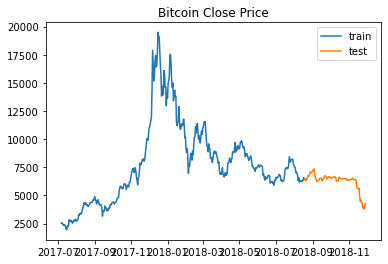

In [214]:
# Plotting
df_btc.index = pd.to_datetime(df_btc['date'])
train = df_btc[int(.75*len(df_btc)):int(.95*len(df_btc))]
test = df_btc[int(.95*len(df_btc)):len(df_btc)]
plt.plot(train['close'])
plt.plot(test['close'])
plt.title("Bitcoin Close Price")
plt.legend(["train", "test"])

(0.762872469489035, True)
(0.01, False)


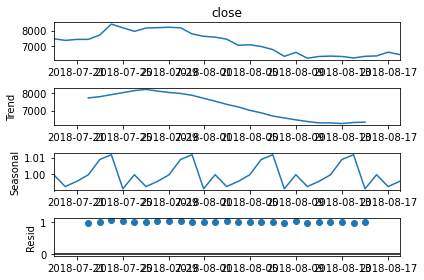

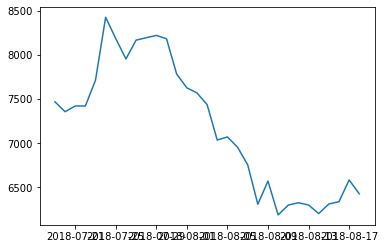

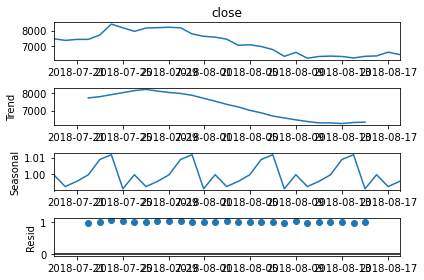

In [215]:
# stationary test
adf_test = ADFTest()
print(adf_test.should_diff(train["close"]))
print(adf_test.should_diff(train["close"].diff(1)[1:]))
plt.plot(train['close'][-31:])
seasonal_decomp = seasonal_decompose(train["close"][-31:], model='multiplicative')
seasonal_decomp.plot()
# seasonal decomp over the last 31 days


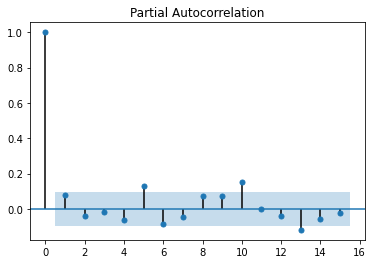

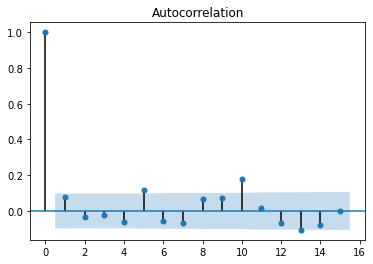

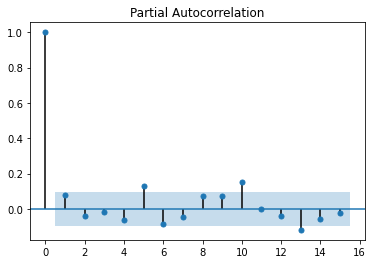

In [216]:
plot_acf(train["close"].diff(1)[1:], lags=15)
plot_pacf(train["close"].diff(1)[1:], lags=15)

#seasonal_decomp.plot()

In [244]:
arima_model = auto_arima(train["close"], start_p = 0, start_d = 0, start_q = 0, 
                         max_p = 5, max_q = 5, max_d = 2, seasonal = True, trace = True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6244.773, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6244.238, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6244.060, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6242.914, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6243.939, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.317 seconds


array([6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76, 6423.76,
       6423.76, 6423

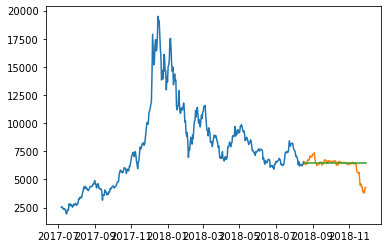

In [241]:
forecasts = arima_model.predict(test.shape[0])
plt.plot(train['close'])
plt.plot(test['close'])
plt.plot(test.index, forecasts)
forecasts
# plt.title("Bitcoin Close Price")
# plt.legend(["train", "test"])

In [242]:
rms = sqrt(mean_squared_error(test['close'], forecasts))
rms

782.1073304078348

## ARIMAX

In [263]:
arima_model_exog = auto_arima(train["close"], start_p = 0, start_d = 0, start_q = 0, 
                         max_p = 5, max_q = 5, max_d = 2, seasonal = True,  
                         stepwise=True, exogenous=(np.array(train['volume']).reshape(-1,1)))


C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWa

In [264]:
forecasts_exog = arima_model_exog.predict(len(test['volume']), exogenous=np.array(test['volume']).reshape(-1, 1))

In [265]:
rms = sqrt(mean_squared_error(test['close'], forecasts_exog))
rms

800.1535262332328

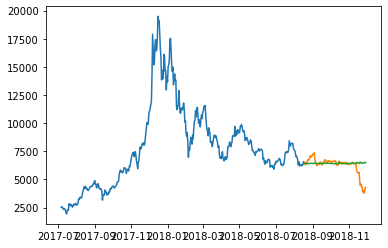

In [266]:
plt.plot(train['close'])
plt.plot(test['close'])
plt.plot(test.index, forecasts_exog)

# LSTM

In [313]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
data = df_btc.filter(['close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) 

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


1574

In [303]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [304]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

Train on 1574 samples
1574/1574 [==============================] - 22s 14ms/sample - loss: 2.0371e-04


In [305]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [306]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

942.2477253326733

C:\Users\aidan\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


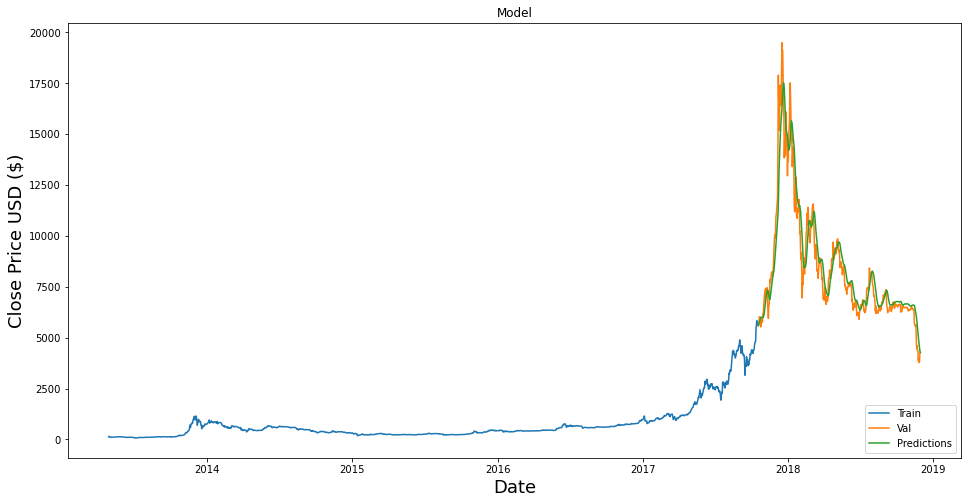

In [308]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


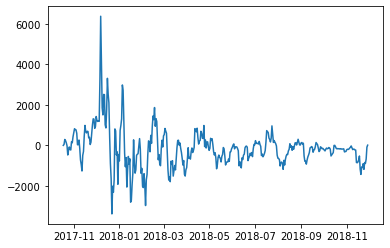

In [314]:
plt.plot(valid['close'] - valid['Predictions'])

## Support Vector Regression